# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

## 2.1 Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds.lwe_thickness
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [5]:
'''
Full catalog - Convert earthquake data to a GeoDataFrame
'''
# Convert longitude and latitude coordinates to Shapely Point objects for spatial operations
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]

# Create a GeoDataFrame with the full earthquake catalog
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  
# EPSG:4326 specifies the coordinate reference system (WGS 84)

# Create a spatial index for fast spatial queries (used for spatial joins)
catalog_gdf_full.sindex  # Improves efficiency when searching for earthquakes within regions


'''
ETAS Declustered Catalog - Convert ETAS declustered earthquake data to a GeoDataFrame
'''
# Convert ETAS declustered catalog's coordinates into Shapely Point objects for spatial analysis
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]

# Create a GeoDataFrame specifically for the ETAS declustered catalog
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")

# Create a spatial index for fast spatial queries in the ETAS declustered dataset
catalog_gdf_etas.sindex  # This allows quick lookups for earthquake locations


In [6]:
def calc_cp_by_mascon(catalog_gdf, loads):
    """
    Calculates conditional probability P(E|L) in every mascon using each mascon's center coordinates 
    and creating a 1.5-degree radius spherical cap around each one.
    
    Parameters:
    - catalog_gdf (GeoDataFrame): A GeoDataFrame containing earthquake data with spatial geometry.
    - loads (xarray DataArray): GRACE-derived surface load dataset.

    Returns:
    - cp_averaged (numpy array): Averaged conditional probabilities P(E|L) across all mascons.
    - bins (numpy array): Bin edges used for probability computation.
    """
    
    cp = []  # List to store conditional probabilities for each mascon

    # Iterate through each mascon center
    # tqdm can be used for progress tracking if needed
    for i in range(len(mascon_id)):
        # Create a Shapely Point object for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Perform a spatial join to find earthquakes located within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # If no earthquakes are found within this cap, move to the next mascon
        if these_earthquakes.empty:
            continue

        # Retrieve surface load data for this mascon at its center coordinates
        L = loads.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # Extract load values at the times of earthquakes occurring in this mascon
        LgE = these_earthquakes.dmass  # Load at earthquake times

        # Number of earthquakes in this mascon (used as probability weight)
        E = len(these_earthquakes)  

        # Compute conditional probability P(E|L) for this mascon
        bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E  # Weight by earthquake probability

        cp.append(this_cp)  # Store computed P(E|L)

    # Compute the average conditional probability across all mascons
    cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return cp_averaged, bins

In [7]:
cp_averaged, bins = calc_cp_by_mascon(catalog_gdf_full, lwe_data)

## 2.2 Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [8]:
etas_cp_averaged, bins = calc_cp_by_mascon(catalog_gdf_etas, lwe_data)

## 2.3 Visualizing correlation for full & declustered catalog

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(14, 4), dpi=120)
fs = 13

### (a) P(E|L) by Mascon (ETAS)
wid_etas = np.mean(np.diff(bins))

axes[0].bar(bins[:-1], etas_cp_averaged / np.sum(etas_cp_averaged), 
       width=wid_etas, align='edge')

axes[0].set_xlim(bins[0], bins[-2])
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability', fontsize=fs)
axes[0].set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
axes[0].grid(True)

### (b) P(E|L) by Mascon (full catalog)
axes[1].bar(bins[:-1], cp_averaged / np.sum(cp_averaged), 
       width=wid_etas, align='edge')

axes[1].set_xlim(bins[0], bins[-2])
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[1].set_ylabel('Conditional probability', fontsize=fs)
axes[1].set_title('(a) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
axes[1].grid(True)

## 3.1 Permutation testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

In [10]:
# Number of randomizations
N = 1000

In [11]:
cp_real_distribution = []  # List to store conditional probabilities from each randomization

# Perform permutation test by shuffling surface loads and recalculating P(E|L)
for i in tqdm(range(N)):  
    # Extract the full surface load dataset (GRACE lwe_thickness) as a NumPy array
    all_grace_data = np.array(ds['lwe_thickness'].values)

    # Flatten the dataset to enable shuffling while maintaining data integrity
    flat_grace = all_grace_data.ravel()

    # Randomly shuffle the flattened surface load data
    np.random.shuffle(flat_grace)

    # Reshape the shuffled data back into its original structure
    shuffled_grace = flat_grace.reshape(all_grace_data.shape)

    # Create a deep copy of the original dataset to avoid modifying the original `ds`
    ds_shuffled = ds.copy(deep=True)

    # Replace the original surface load data with the shuffled version
    ds_shuffled['lwe_thickness'].values = shuffled_grace

    # Recalculate conditional probability P(E|L) using the shuffled dataset
    cp_shuffled, bins = calc_cp_by_mascon(catalog_gdf_full, ds_shuffled['lwe_thickness'])
    
    # Store the computed conditional probabilities from this iteration
    cp_real_distribution.append(cp_shuffled)

# Convert the list of probability distributions to a NumPy array for efficient computation
cp_real_distribution = np.array(cp_real_distribution)  # Shape: (N, num_bins)

# Compute the final averaged probability distribution across all permutations
cp_real_distribution_avg = np.mean(cp_real_distribution, axis=0)  # Shape: (num_bins,)

100%|████████████████████████████████████| 1000/1000 [10:01:43<00:00, 36.10s/it]


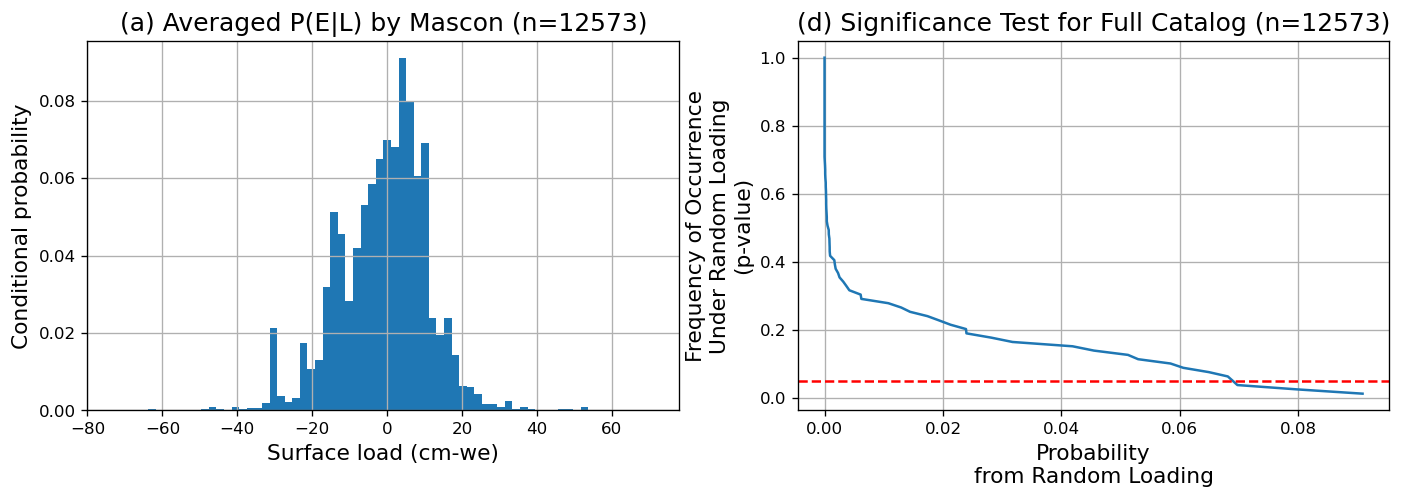

In [17]:
fig, ax = plt.subplots(1,2, figsize=(14, 4), dpi=120)
fs = 13
wid_etas = np.mean(np.diff(bins))

### (b) P(E|L) by Mascon (full catalog)
ax[0].bar(bins[:-1], cp_real_distribution_avg / np.sum(cp_real_distribution_avg), 
       width=wid_etas, align='edge')

ax[0].set_xlim(bins[0], bins[-2])
ax[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
ax[0].set_ylabel('Conditional probability', fontsize=fs)
ax[0].set_title('(a) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
ax[0].grid(True)

sorted_data = np.sort(cp_real_distribution_avg)  # Use final averaged version
ax[1].plot(sorted_data / np.sum(cp_real_distribution_avg) , 1 - np.arange(sorted_data.size) / sorted_data.size)
ax[1].axhline(y=0.05, color='r', linestyle='--')
ax[1].set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax[1].set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax[1].set_title('(d) Significance Test for Full Catalog (n=12573)', fontsize=fs + 2)
ax[1].grid(True)

## 3.2  Repeating analysis for ETAS declustered catalog

In [13]:
etas_cp_real_distribution = []

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    all_grace_data = ds['lwe_thickness'].values
    flat_grace = all_grace_data.ravel()
    np.random.shuffle(flat_grace)
    shuffled_grace = flat_grace.reshape(all_grace_data.shape)

    ds['lwe_thickness'] = (ds['lwe_thickness'].dims, shuffled_grace)
    etas_cp_shuffled, bins = calc_cp_by_mascon(catalog_gdf_etas, ds['lwe_thickness'])
    etas_cp_real_distribution.append(etas_cp_shuffled)

# Convert to NumPy array for proper averaging
etas_cp_real_distribution = np.array(etas_cp_real_distribution)  # Shape: (N, num_bins)

# Compute final averaged probability distribution
etas_cp_real_distribution_avg = np.mean(etas_cp_real_distribution, axis=0)  # Shape: (num_bins,)

100%|████████████████████████████████████| 1000/1000 [16:09:22<00:00, 58.16s/it]


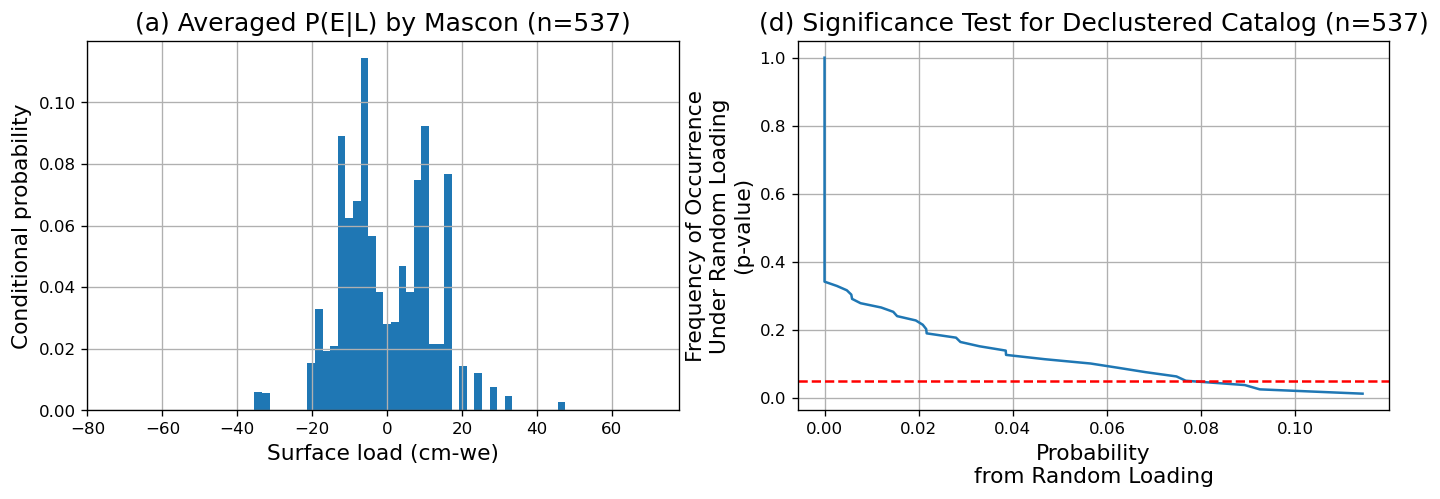

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14, 4), dpi=120)
fs = 13
wid_etas = np.mean(np.diff(bins))

### (b) P(E|L) by Mascon (declustered catalog)
ax[0].bar(bins[:-1], etas_cp_real_distribution_avg / np.sum(etas_cp_real_distribution_avg), 
       width=wid_etas, align='edge')

ax[0].set_xlim(bins[0], bins[-2])
ax[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
ax[0].set_ylabel('Conditional probability', fontsize=fs)
ax[0].set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax[0].grid(True)

sorted_data = np.sort(etas_cp_real_distribution_avg)  # Use final averaged version
ax[1].plot(sorted_data / np.sum(etas_cp_real_distribution_avg) , 1 - np.arange(sorted_data.size) / sorted_data.size)
ax[1].axhline(y=0.05, color='r', linestyle='--')
ax[1].set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax[1].set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax[1].set_title('(d) Significance Test for Declustered Catalog (n=537)', fontsize=fs + 2)
ax[1].grid(True)

## 4. Figures

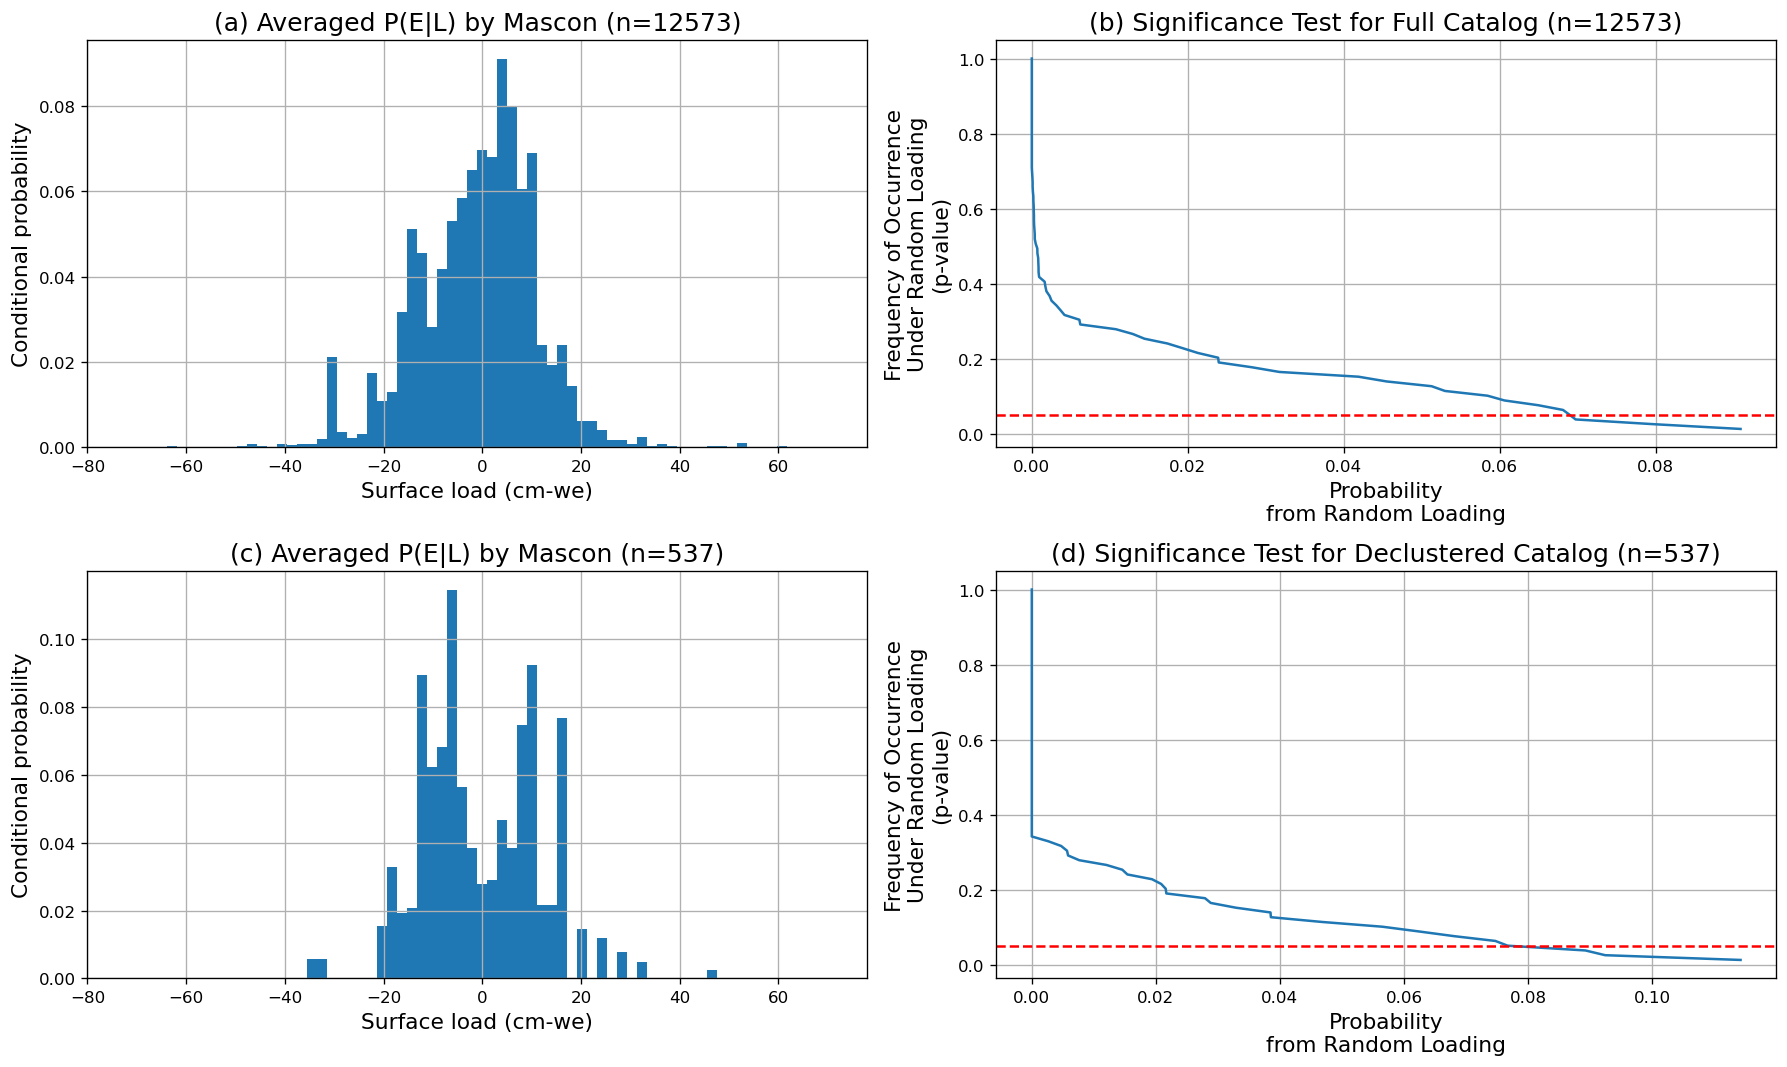

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 9), dpi=120)
fs = 13

wid_etas = np.mean(np.diff(bins))

### (a) P(E|L) by Mascon (full catalog)
ax[0, 0].bar(bins[:-1], cp_real_distribution_avg / np.sum(cp_real_distribution_avg), 
             width=wid_etas, align='edge')

ax[0, 0].set_xlim(bins[0], bins[-2])
ax[0, 0].set_xlabel('Surface load (cm-we)', fontsize=fs)
ax[0, 0].set_ylabel('Conditional probability', fontsize=fs)
ax[0, 0].set_title('(a) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
ax[0, 0].grid(True)

sorted_data = np.sort(cp_real_distribution_avg)  # Use final averaged version
ax[0, 1].plot(sorted_data / np.sum(cp_real_distribution_avg), 
              1 - np.arange(sorted_data.size) / sorted_data.size)

ax[0, 1].axhline(y=0.05, color='r', linestyle='--')
ax[0, 1].set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax[0, 1].set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax[0, 1].set_title('(b) Significance Test for Full Catalog (n=12573)', fontsize=fs + 2)
ax[0, 1].grid(True)

### (c) P(E|L) by Mascon (declustered catalog)
ax[1, 0].bar(bins[:-1], etas_cp_real_distribution_avg / np.sum(etas_cp_real_distribution_avg), 
             width=wid_etas, align='edge')

ax[1, 0].set_xlim(bins[0], bins[-2])
ax[1, 0].set_xlabel('Surface load (cm-we)', fontsize=fs)
ax[1, 0].set_ylabel('Conditional probability', fontsize=fs)
ax[1, 0].set_title('(c) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax[1, 0].grid(True)

sorted_data = np.sort(etas_cp_real_distribution_avg)  # Use final averaged version
ax[1, 1].plot(sorted_data / np.sum(etas_cp_real_distribution_avg), 
              1 - np.arange(sorted_data.size) / sorted_data.size)

ax[1, 1].axhline(y=0.05, color='r', linestyle='--')
ax[1, 1].set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax[1, 1].set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax[1, 1].set_title('(d) Significance Test for Declustered Catalog (n=537)', fontsize=fs + 2)
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()